### Présentation du notebook:

Dans ce notebook, nous allons extraire des caractéristiques à partir des descriptions de produits en utilisant différentes techniques de traitement du texte. Nous allons explorer les méthodes suivantes pour générer des embeddings de texte :
- Bag-of-Words (CountVectorizer et TF-IDF)
- Word2Vec
- BERT (Bidirectional Encoder Representations from Transformers)
- USE (Universal Sentence Encoder)
- Nous allons également sauvegarder les embeddings générés pour une utilisation future.
- Les données utilisées sont issues du dataset "flipkart_com-ecommerce_sample_1050.csv" qui contient des informations sur des produits vendus en ligne.
- Les catégories de produits seront également préparées pour l'entraînement de modèles de classification.
- Les données prétraitées seront sauvegardées pour une utilisation future.


### Cellule 1 : Importation des librairies essentielles python

In [125]:
# Import des librairies essentielles
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


### Cellule 2 : Importation des données

In [126]:
# Définir le chemin relatif
file_path = os.path.join("..", "data", "flipkart_com-ecommerce_sample_1050.csv")

# Chargement du dataset des produits
data = pd.read_csv(file_path)
print("Dimensions du dataset :", data.shape)


Dimensions du dataset : (1050, 15)


### Cellule 3 : Affichage d'un aperçu des données

In [127]:
# Afficher les premières lignes du dataset
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa..."
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",..."
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v..."
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa..."


### Cellule 4 : Vérification des colonnes disponibles

In [128]:
# Afficher les noms des colonnes
print("Colonnes du dataset :", data.columns.tolist())


Colonnes du dataset : ['uniq_id', 'crawl_timestamp', 'product_url', 'product_name', 'product_category_tree', 'pid', 'retail_price', 'discounted_price', 'image', 'is_FK_Advantage_product', 'description', 'product_rating', 'overall_rating', 'brand', 'product_specifications']


### Cellule 9 : Préparation des catégories

In [129]:
# Extraire la première catégorie de la colonne 'product_category_tree' en retirant les crochets, guillemets et espaces supplémentaires
data['category'] = data['product_category_tree'].apply(lambda x: x.strip("[]").replace('"', '').split(">>")[0].replace("'", "").strip())

# Mettre les catégories en minuscules pour uniformiser
data['category'] = data['category'].apply(lambda x: x.lower())

# Remplacer les valeurs manquantes dans 'category' par 'unknown'
data['category'] = data['category'].fillna('unknown')

# Liste des catégories uniques
categories = data['category'].unique().tolist()
print("Catégories :", categories)

# Mapping des catégories vers des numéros
category_to_num = {category: idx for idx, category in enumerate(categories)}
data['category_num'] = data['category'].map(category_to_num)

# Extraire les numéros de catégories
y_cat_num = data['category_num'].values # permet de récupérer les numéros de catégories en tant que tableau numpy
print("Numéros de catégories :", y_cat_num)


Catégories : ['home furnishing', 'baby care', 'watches', 'home decor & festive needs', 'kitchen & dining', 'beauty and personal care', 'computers']
Numéros de catégories : [0 1 1 ... 1 1 1]


In [130]:
data.head(20)

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,category_num
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,0
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby care,1
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby care,1
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,0
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing,0
5,893aa5ed55f7cff2eccea7758d7a86bd,2015-12-04 07:25:36 +0000,http://www.flipkart.com/maserati-time-r8851116...,Maserati Time R8851116001 Analog Watch - For ...,"[""Watches >> Wrist Watches >> Maserati Time Wr...",WATEAYAHJ8CUCAYM,24400.0,24400.0,893aa5ed55f7cff2eccea7758d7a86bd.jpg,False,Maserati Time R8851116001 Analog Watch - For ...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",watches,2
6,f355cc1ccb08bd0d283ed979b7ee7515,2015-12-04 07:25:36 +0000,http://www.flipkart.com/camerii-wm64-elegance-...,"Camerii WM64 Elegance Analog Watch - For Men,...","[""Watches >> Wrist Watches >> Camerii Wrist Wa...",WATE6Y6D2MZHWGBZ,1099.0,449.0,f355cc1ccb08bd0d283ed979b7ee7515.jpg,False,"Camerii WM64 Elegance Analog Watch - For Men,...",5,5,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",watches,2
7,dd0e3470a7e6ed76fd69c2da27721041,2015-12-04 07:25:36 +0000,http://www.flipkart.com/t-star-uft-tsw-005-bk-...,T STAR UFT-TSW-005-BK-BR Analog Watch - For Boys,"[""Watches >> Wrist Watches >> T STAR Wrist Wat...",WATECFFVGFZPAD3D,999.0,399.0,dd0e3470a7e6ed76fd69c2da27721041.jpg,False,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Chronograp...",watches,2
8,41384da51732c0b4df3de8f395714fbb,2015-12-04 07:25:36 +0000,http://www.flipkart.com/alfajr-wy16b-youth-dig...,"Alfajr WY16B Youth Digital Watch - For Men, Boys","[""Watches >> Wrist Watches 

In [131]:
# nombre de catégories avec noms des catégories
print("Nombre de catégories :", len(categories))

# Affichage du nombre de produits par catégorie
data.groupby("category").count()

Nombre de catégories : 7


,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category_num
category,,,,,,,,,,,,,,,,
baby care,150,150,150,150,150,150,149,149,150,150,150,150,150,134,150,150
beauty and personal care,150,150,150,150,150,150,150,150,150,150,150,150,150,41,150,150
computers,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
home decor & festive needs,150,150,150,150,150,150,150,150,150,150,150,150,150,148,149,150
home furnishing,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150,150
kitchen & dining,150,150,150,150,150,150,150,150,150,150,150,150,150,79,150,150
watches,150,150,150,150,150,150,150,150,150,150,150,150,150,10,150,150


### Cellule 5 : Préparation du traitement du texte

In [132]:
# Import des librairies pour le traitement du texte
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Téléchargement des ressources NLTK (à exécuter une seule fois)
nltk.download('punkt') # punkt est un tokenizer
nltk.download('stopwords') # stopwords est une liste de mots vides
nltk.download('wordnet') # wordnet est une base de données lexicale


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\pat\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\pat\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\pat\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [133]:
 # Check import nltk
from nltk.tokenize import word_tokenize

# Exemple de texte
texte = "Bonjour, ceci est un test de tokenisation."

# Tokenisation du texte
tokens = word_tokenize(texte)

# Affichage des tokens
print(tokens)

['Bonjour', ',', 'ceci', 'est', 'un', 'test', 'de', 'tokenisation', '.']


### Cellule 6 : Définition des fonctions de prétraitement

In [134]:
# Fonction de tokenisation
def tokenizer_fct(sentence):
    sentence_clean = sentence.replace('-', ' ').replace('+', ' ').replace('/', ' ').replace('#', ' ')
    word_tokens = word_tokenize(sentence_clean)
    return word_tokens

# Liste des stop words
stop_w = set(stopwords.words('english'))
punctuations = ['[', ']', ',', '.', ':', '?', '(', ')', '!', ';', '"', "'", '&', '%', '$', '@', '#', '*', '–', '—', '...']
stop_w.update(punctuations)

# Fonction de filtrage des stop words
def stop_word_filter_fct(list_words):
    filtered_w = [w for w in list_words if not w.lower() in stop_w] # stop words en minuscules
    filtered_w2 = [w for w in filtered_w if len(w) > 2] # suppression des mots de moins de 3 caractères
    return filtered_w2 # retourne la liste des mots filtrés

# Fonction de mise en minuscule et suppression de certains mots
def lower_start_fct(list_words):
    lw = [w.lower() for w in list_words if not w.startswith("@") and not w.startswith("#") and not w.startswith("http")] # suppression des mots commençant par @, #, http
    return lw # retourne la liste des mots en minuscules

# Fonction de lemmatisation
def lemma_fct(list_words):
    lemmatizer = WordNetLemmatizer() # Initialisation de l'outil de lemmatisation
    lem_w = [lemmatizer.lemmatize(w) for w in list_words] # lemmatisation des mots de la liste, exemple : pris -> prendre
    return lem_w # retourne la liste des mots lemmatisés

# Fonction de préparation du texte pour Bag-of-Words
def transform_bow_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text) # Tokenisation du texte, exemple : "Bonjour, ceci est un test de tokenisation." -> ['Bonjour', ',', 'ceci', 'est', 'un', 'test', 'de', 'tokenisation', '.']
    sw = stop_word_filter_fct(word_tokens) # Filtrage des stop words, exemple : ['Bonjour', 'test', 'tokenisation']
    lw = lower_start_fct(sw) # Mise en minuscule et suppression de certains mots, exemple des mots commençant par @, #, http
    transf_desc_text = ' '.join(lw) # Concaténation des mots de la liste en une chaîne de caractères, exemple : "bonjour test tokenisation"
    return transf_desc_text # Retourne la chaîne de caractères préparée

# Fonction de préparation du texte pour Bag-of-Words avec lemmatisation
def transform_bow_lem_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text) # Tokenisation du texte, exemple : "Bonjour, ceci est un test de tokenisation." -> ['Bonjour', ',', 'ceci', 'est', 'un', 'test', 'de', 'tokenisation', '.']
    sw = stop_word_filter_fct(word_tokens) # Filtrage des stop words, exemple : ['Bonjour', 'test', 'tokenisation']
    lw = lower_start_fct(sw) # Mise en minuscule et suppression de certains mots, exemple des mots commençant par @, #, http
    lem_w = lemma_fct(lw) # Lemmatisation des mots, exemple pris -> prendre
    transf_desc_text = ' '.join(lem_w) # Concaténation des mots de la liste en une chaîne de caractères, exemple : "bonjour test tokenisation"
    return transf_desc_text # Retourne la chaîne de caractères préparée

# Fonction de préparation du texte pour les modèles de Deep Learning (BERT, USE)
def transform_dl_fct(desc_text):
    word_tokens = tokenizer_fct(desc_text) # Tokenisation du texte, exemple : "Bonjour, ceci est un test de tokenisation." -> ['Bonjour', ',', 'ceci', 'est', 'un', 'test', 'de', 'tokenisation', '.']
    lw = lower_start_fct(word_tokens) # Mise en minuscule et suppression de certains mots, exemple des mots commençant par @, #, http
    transf_desc_text = ' '.join(lw) # Concaténation des mots de la liste en une chaîne de caractères, exemple : "bonjour test tokenisation"
    return transf_desc_text # Retourne la chaîne de caractères préparée


### Cellule 7 : Application du prétraitement

In [135]:
# Remplacer les valeurs manquantes dans 'description' par une chaîne vide
data['description'] = data['description'].fillna('') # Remplacer les valeurs manquantes par une chaîne vide

# Application des fonctions de prétraitement pour les descriptions de produits dans l'ordre suivant : transform_bow_fct, transform_bow_lem_fct, transform_dl_fct
data['sentence_bow'] = data['description'].apply(lambda x: transform_bow_fct(str(x))) # Bag-of-Words sans lemmatisation, la lemmatisation est une étape de normalisation linguistique qui consiste à réduire les mots fléchis à leur forme canonique
data['sentence_bow_lem'] = data['description'].apply(lambda x: transform_bow_lem_fct(str(x))) # Bag-of-Words avec lemmatisation, bag-of-words est une méthode de représentation de documents textuels utilisée en traitement automatique du langage naturel et en recherche d'information
data['sentence_dl'] = data['description'].apply(lambda x: transform_dl_fct(str(x))) # Pour les modèles de Deep Learning, sentence_dl est la colonne qui contient les descriptions de produits prétraitées pour les modèles de Deep Learning (BERT, USE)

print("Dimensions du dataset après prétraitement :", data.shape) # Affichage des dimensions du dataset après prétraitement


Dimensions du dataset après prétraitement : (1050, 20)


In [136]:
# affichage colonnes après prétraitement sur les descriptions 10 lignes
data[['description', 'sentence_bow', 'sentence_bow_lem', 'sentence_dl']].head(10)

,description,sentence_bow,sentence_bow_lem,sentence_dl
0,Key Features of Elegance Polyester Multicolor ...,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,Specifications of Sathiyas Cotton Bath Towel (...,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...
2,Key Features of Eurospa Cotton Terry Face Towe...,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...
3,Key Features of SANTOSH ROYAL FASHION Cotton P...,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...
4,Key Features of Jaipur Print Cotton Floral Kin...,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...
5,Maserati Time R8851116001 Analog Watch - For ...,maserati time r8851116001 analog watch boys bu...,maserati time r8851116001 analog watch boy buy...,maserati time r8851116001 analog watch for boy...
6,"Camerii WM64 Elegance Analog Watch - For Men,...",camerii wm64 elegance analog watch men boys bu...,camerii wm64 elegance analog watch men boy buy...,"camerii wm64 elegance analog watch for men , b..."
7,T STAR UFT-TSW-005-BK-BR Analog Watch - For B...,star uft tsw 005 analog watch boys price 399 w...,star uft tsw 005 analog watch boy price 399 wh...,t star uft tsw 005 bk br analog watch for boys...
8,"Alfajr WY16B Youth Digital Watch - For Men, B...",alfajr wy16b youth digital watch men boys buy ...,alfajr wy16b youth digital watch men boy buy a...,"alfajr wy16b youth digital watch for men , boy..."
9,TAG Heuer CAU1116.BA0858 Formula 1 Analog Watc...,tag heuer cau1116.ba0858 formula analog watch ...,tag heuer cau1116.ba0858 formula analog watch ...,tag heuer cau1116.ba0858 formula 1 analog watc...


In [137]:
# maximum de caractères dans la colonne 'description'
max_len = data['description'].apply(lambda x: len(x)).max()
print("Nombre maximum de caractères dans la colonne 'description' :", max_len)
# maximum de mots dans la colonne 'sentence_bow'
max_len = data['sentence_bow'].apply(lambda x: len(x.split())).max()
print("Nombre maximum de mots dans la colonne 'sentence_bow' :", max_len)
# maximum de mots dans la colonne 'sentence_bow_lem'
max_len = data['sentence_bow_lem'].apply(lambda x: len(x.split())).max()
print("Nombre maximum de mots dans la colonne 'sentence_bow_lem' :", max_len)
# maximum de mots dans la colonne 'sentence_dl'
max_len = data['sentence_dl'].apply(lambda x: len(x.split())).max()
print("Nombre maximum de mots dans la colonne 'sentence_dl' :", max_len)

Nombre maximum de caractères dans la colonne 'description' : 3490
Nombre maximum de mots dans la colonne 'sentence_bow' : 361
Nombre maximum de mots dans la colonne 'sentence_bow_lem' : 361
Nombre maximum de mots dans la colonne 'sentence_dl' : 631


### Glossaire des colonnes ajoutées :
- description : Description de produit brute sans prétraitement.
- sentence_bow : Description de produit prétraitée pour Bag-of-Words sans lemmatisation (normalisation linguistique).
- sentence_bow_lem : Description de produit prétraitée pour Bag-of-Words avec lemmatisation (normalisation linguistique).
- sentence_dl : Description de produit prétraitée pour les modèles de Deep Learning (BERT, USE). Pour ces modèles, la lemmatisation n'est pas nécessaire mais la mise en minuscule et la suppression de certains mots sont effectuées.

### Observation :
- Les colonnes 'sentence_bow' et 'sentence_bow_lem' contiennent des descriptions de produits prétraitées pour les méthodes Bag-of-Words (BoW) avec et sans lemmatisation. On constate que la lemmatisation n'a pas d'impact sur la longueur des descriptions. Cela est dû au fait que la lemmatisation réduit les mots fléchis à leur forme canonique, mais ne modifie pas le nombre de mots.
- La colonne 'sentence_dl' contient des descriptions de produits prétraitées pour les modèles de Deep Learning (BERT, USE). On observe que les descriptions sont plus longues que celles des colonnes 'sentence_bow' et 'sentence_bow_lem'. Cela est dû au fait que les traitements de prétraitement sont différents pour les modèles de Deep Learning, et que les descriptions sont conservées dans leur forme brute sans lemmatisation.

In [138]:
# Affichage des premières lignes du dataset après prétraitement
data.head()

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,category,category_num,sentence_bow,sentence_bow_lem,sentence_dl
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,0,key features elegance polyester multicolor abs...,key feature elegance polyester multicolor abst...,key features of elegance polyester multicolor ...
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",baby care,1,specifications sathiyas cotton bath towel bath...,specification sathiyas cotton bath towel bath ...,specifications of sathiyas cotton bath towel (...
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",baby care,1,key features eurospa cotton terry face towel s...,key feature eurospa cotton terry face towel se...,key features of eurospa cotton terry face towe...
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",home furnishing,0,key features santosh royal fashion cotton prin...,key feature santosh royal fashion cotton print...,key features of santosh royal fashion cotton p...
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",home furnishing,0,key features jaipur print cotton floral king s...,key feature jaipur print cotton floral king si...,key features of jaipur print cotton floral kin...


### Cellule 8 : Sauvegarde des données prétraitées (optionnel)

In [139]:
import os

# Définir le chemin relatif vers le dossier "data"
file_path = os.path.join("..", "data", "preprocessed_product_data.csv")

# Sauvegarde du dataset prétraité pour une utilisation future
data.to_csv(file_path, index=False)


In [140]:
print(data.columns)


Index(['uniq_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'category',
       'category_num', 'sentence_bow', 'sentence_bow_lem', 'sentence_dl'],
      dtype='object')


In [141]:
import os
import pandas as pd

# Définition du chemin vers le fichier CSV
file_path = os.path.join("..", "data", "preprocessed_product_data.csv")

# Lecture des données
data = pd.read_csv(file_path)

# Affichage de la forme du DataFrame (nombre de lignes et de colonnes)
print(data.shape)

(1050, 20)


### Fonctions communes 

In [142]:
from sklearn import manifold, metrics, cluster
import time
import numpy as np
import matplotlib.pyplot as plt

# Calcul du t-SNE, détermination des clusters, et calcul de l'ARI
def ARI_fct(features):
    time1 = time.time()
    num_labels = len(categories)  # 'categories' contient les catégories de produits uniques
    tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, 
                         init='random', learning_rate=200, random_state=42)
    X_tsne = tsne.fit_transform(features)
    
    # Détermination des clusters à partir des données réduites par t-SNE
    cls = cluster.KMeans(n_clusters=num_labels, n_init=100, random_state=42)
    cls.fit(X_tsne)
    
    # Calcul de l'Adjusted Rand Index (ARI)
    ARI = np.round(metrics.adjusted_rand_score(y_cat_num, cls.labels_), 4)
    time2 = np.round(time.time() - time1, 0)
    print("ARI : ", ARI, "time : ", time2)
    
    return ARI, X_tsne, cls.labels_

# Visualisation du t-SNE selon les vraies catégories et les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI):
    fig = plt.figure(figsize=(15, 6))
    
    # Visualisation avec les vraies catégories
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=categories, loc="best", title="Catégorie")
    plt.title('Représentation des produits par catégories réelles')
    
    # Visualisation avec les clusters
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="best", title="Clusters")
    plt.title('Représentation des produits par clusters')
    
    plt.show()
    print("ARI : ", ARI)



### Cellule 10 : Extraction des features avec Bag-of-Words et TF-IDF
- Nous allons extraire des caractéristiques à partir des descriptions de produits en utilisant les méthodes Bag-of-Words (BoW) et Term Frequency-Inverse Document Frequency (TF-IDF).
- Nous allons utiliser les outils de prétraitement de texte de NLTK pour nettoyer et lemmatiser les descriptions de produits.
- La technique BoW consiste à représenter chaque document par un vecteur de fréquence des mots présents dans le document.
- La technique TF-IDF est similaire à BoW, mais elle pondère les fréquences des mots par leur importance dans le corpus.
- Nous allons utiliser les implémentations de CountVectorizer et TfidfVectorizer de scikit-learn pour extraire les caractéristiques des descriptions de produits.

### Préparation sentence_bow_lem

In [143]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Initialisation des vectoriseurs
cvect = CountVectorizer(stop_words='english', max_df=0.95, min_df=1)
tfidf_vect = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=1)

# Sélection de la colonne à utiliser
feat = 'sentence_bow_lem' # Utilisation de la colonne 'sentence_bow_lem' pour les features car elle contient les catégories de produits nettoyées et lemmatisées

# Ajustement et transformation des données
cv_fit = cvect.fit(data[feat])
tfidf_fit = tfidf_vect.fit(data[feat])

cv_transform = cvect.transform(data[feat])
tfidf_transform = tfidf_vect.transform(data[feat])


### Exécution des modèles avec ARI, t-SNE et visualisation comme métriques

In [144]:
# Exécution de la fonction ARI avec les features extraites, cv_transform est la matrice de features pour le CountVectorizer
print("CountVectorizer : ") # CountVectorizer est une méthode de vectorisation de texte qui convertit une collection de documents texte en une matrice de comptage de tokens
print("-----------------")
ARI, X_tsne, labels = ARI_fct(cv_transform) # ARI est l'Adjusted Rand Index, X_tsne est la représentation t-SNE des données, labels sont les clusters prédits
print()
print("Tf-idf : ") # TF-IDF (Term Frequency-Inverse Document Frequency) est une méthode de vectorisation de texte qui convertit une collection de documents texte en une matrice de fréquence de tokens pondérée par l'inverse de la fréquence du document
print("--------")
# Exécution de la fonction ARI avec les features extraites, tfidf_transform est la matrice de features pour le TF-IDF
ARI, X_tsne, labels = ARI_fct(tfidf_transform) # ARI est l'Adjusted Rand Index, X_tsne est la représentation t-SNE des données, labels sont les clusters prédits

CountVectorizer : 
-----------------


C:\Users\pat\.conda\envs\P6q\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.3759 time :  14.0

Tf-idf : 
--------


C:\Users\pat\.conda\envs\P6q\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


ARI :  0.4698 time :  12.0


### Graphiques des résultats

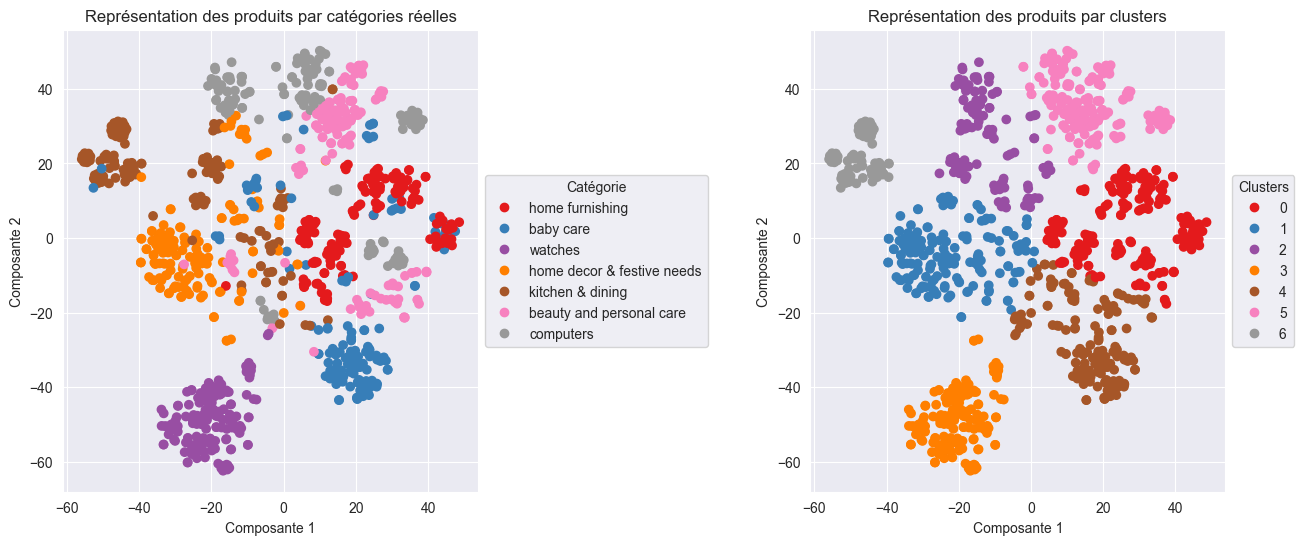

ARI :  0.4698


In [145]:
# Visualisation du t-SNE selon les vraies catégories et selon les clusters
def TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, categories):
    fig = plt.figure(figsize=(15,6))
    
    # Ajustement de l'espacement entre les graphiques
    plt.subplots_adjust(wspace=0.8)  # Augmenter encore l'espace entre les sous-graphiques
    
    # Premier graphique : représentation selon les vraies catégories
    ax = fig.add_subplot(121)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=y_cat_num, cmap='Set1')
    # Déplacement de la légende à droite
    ax.legend(handles=scatter.legend_elements()[0], labels=categories, loc="center left", bbox_to_anchor=(1, 0.5), title="Catégorie")
    ax.set_title('Représentation des produits par catégories réelles')
    ax.set_xlabel('Composante 1')  # Ajout du label des abscisses
    ax.set_ylabel('Composante 2')  # Ajout du label des ordonnées
    
    # Deuxième graphique : représentation selon les clusters
    ax = fig.add_subplot(122)
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='Set1')
    ax.legend(handles=scatter.legend_elements()[0], labels=set(labels), loc="center left", bbox_to_anchor=(1, 0.5), title="Clusters")
    ax.set_title('Représentation des produits par clusters')
    ax.set_xlabel('Composante 1')  # Ajout du label des abscisses
    ax.set_ylabel('Composante 2')  # Ajout du label des ordonnées

    plt.show()
    print("ARI : ", ARI)

# Appel de la fonction avec la liste des catégories
TSNE_visu_fct(X_tsne, y_cat_num, labels, ARI, categories)

### Observations

1. **T-SNE** permet de visualiser les produits dans un espace réduit à deux dimensions, en conservant les relations locales entre les produits similaires. Toutefois, il peut parfois distordre les relations à longue distance, ce qui rend la visualisation des catégories réelles moins claire.
   
2. **K-means** a mieux réussi à regrouper les produits dans des clusters plus distincts. Le graphique de droite montre des groupes mieux définis que le graphique des catégories réelles à gauche. Cela suggère que les descriptions textuelles des produits capturent des relations que les catégories réelles ne parviennent pas à révéler.

3. L'**ARI (Adjusted Rand Index)**, avec un score de 0.4698, indique une différence notable entre les catégories réelles et les clusters prédits par K-means, mais cette différence n'est pas nécessairement négative. Cela peut indiquer que les catégories actuelles sont soit trop larges, soit mal définies.

4. **K-means** a révélé des similarités entre les produits que les catégories réelles n'ont pas su capter, indiquant que les descriptions textuelles offrent des informations supplémentaires ou plus nuancées que les catégories standards.

5. En résumé, **K-means** semble fournir une classification plus cohérente des produits en fonction des descriptions textuelles, suggérant que les catégories actuelles des produits pourraient être affinées ou repensées pour mieux correspondre aux données réelles.

### Cellule 11 : Sauvegarde des embeddings Bag-of-Words

In [146]:
import os
import numpy as np

# Conversion en format dense (attention à la taille de la matrice)
cv_features = cv_transform.toarray()

# Vérification ou création de la colonne 'product_id'
if 'uniq_id' in data.columns:
    data.rename(columns={'uniq_id': 'product_id'}, inplace=True)
elif 'product_id' not in data.columns:
    data['product_id'] = data.index

product_ids = data['product_id'].values

# Définir le chemin relatif vers le dossier "data"
output_file = os.path.join("..", "data", "countvectorizer_embeddings.npz")

# Sauvegarde des embeddings et des identifiants de produits dans le dossier data
np.savez_compressed(output_file, product_id=product_ids, embeddings=cv_features)
print(f"Embeddings have been saved to: {output_file}")



Embeddings have been saved to: ..\data\countvectorizer_embeddings.npz


### Cellule 12 : Sauvegarde des embeddings TF-IDF

In [147]:
import os
import numpy as np

# Conversion en format dense
tfidf_features = tfidf_transform.toarray()

# Vérification ou création de la colonne 'product_id'
if 'product_id' not in data.columns:
    data['product_id'] = data.index

product_ids = data['product_id'].values

# Définir le chemin relatif vers le dossier "data"
output_file = os.path.join("..", "data", "tfidf_embeddings.npz")

# Sauvegarde des embeddings et des identifiants de produits dans le dossier data
np.savez_compressed(output_file, product_id=product_ids, embeddings=tfidf_features)
print(f"TF-IDF Embeddings have been saved to: {output_file}")


TF-IDF Embeddings have been saved to: ..\data\tfidf_embeddings.npz


### Cellule 13 : Extraction des features avec Word2Vec

In [148]:
import os
import gensim
import numpy as np

# Préparation des phrases pour Word2Vec
sentences = data['sentence_bow_lem'].apply(lambda x: x.split()).tolist()

# Paramètres du modèle Word2Vec
w2v_size = 300
w2v_window = 5
w2v_min_count = 1
w2v_epochs = 100

# Entraînement du modèle Word2Vec
print("Building and training the Word2Vec model...")

w2v_model = gensim.models.Word2Vec(
    vector_size=w2v_size,
    window=w2v_window,
    min_count=w2v_min_count,
    seed=42,
    workers=4
)

# Construction du vocabulaire
w2v_model.build_vocab(sentences)
vocab_size = len(w2v_model.wv.index_to_key)
print(f"Vocabulary size: {vocab_size}")  # Taille du vocabulaire

# Entraînement du modèle
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=w2v_epochs)
print("Word2Vec training complete")

# Fonction pour obtenir l'embedding d'un document
def document_vector(doc):
    doc = [word for word in doc if word in w2v_model.wv.key_to_index]
    return np.mean(w2v_model.wv[doc], axis=0) if len(doc) > 0 else np.zeros(w2v_size)

# Création des embeddings pour chaque description
w2v_embeddings = np.array([document_vector(doc) for doc in sentences])

# Sauvegarde des embeddings Word2Vec dans le dossier data
output_file_embeddings = os.path.join("..", "data", "word2vec_embeddings.npz")
np.savez_compressed(output_file_embeddings, embeddings=w2v_embeddings)
print(f"Embeddings have been saved to: {output_file_embeddings}")

# Sauvegarde du modèle Word2Vec dans le dossier models
output_file_model = os.path.join("..", "models", "word2vec_model.model")
w2v_model.save(output_file_model)
print(f"Word2Vec model has been saved to: {output_file_model}")


Building and training the Word2Vec model...
Vocabulary size: 5737
Word2Vec training complete
Embeddings have been saved to: ..\data\word2vec_embeddings.npz
Word2Vec model has been saved to: ..\models\word2vec_model.model


### Cellule 14 : Extraction des features avec BERT


In [149]:
import os
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
import numpy as np
import warnings

# Ignorer les avertissements spécifiques
warnings.filterwarnings("ignore", category=FutureWarning, module="transformers")

# Paramètres
max_length = 64
batch_size = 32
model_name = 'bert-base-uncased'

# Chargement du tokenizer et du modèle BERT
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.clean_up_tokenization_spaces = True  # Optionnel, pour supprimer le FutureWarning
model = TFAutoModel.from_pretrained(model_name)

# Préparation des inputs
sentences = data['sentence_dl'].tolist()

def bert_encode(sentences, tokenizer, max_length):
    input_ids = []
    attention_masks = []

    for sentence in sentences:
        encoded = tokenizer(
            sentence,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
    return tf.concat(input_ids, axis=0), tf.concat(attention_masks, axis=0)

input_ids, attention_masks = bert_encode(sentences, tokenizer, max_length)

# Génération des embeddings
embeddings = []
num_examples = len(sentences)

for i in range(0, num_examples, batch_size):
    batch_input_ids = input_ids[i:i + batch_size]
    batch_attention_masks = attention_masks[i:i + batch_size]
    outputs = model(batch_input_ids, attention_mask=batch_attention_masks)
    # Utilisation de la représentation du token [CLS]
    batch_embeddings = outputs.last_hidden_state[:, 0, :].numpy()
    embeddings.append(batch_embeddings)

bert_embeddings = np.vstack(embeddings)

# Assurez-vous que 'product_ids' est défini
if 'product_id' in data.columns:
    product_ids = data['product_id'].tolist()
else:
    # Création de 'product_id' s'il n'existe pas
    product_ids = list(range(len(data)))

# Sauvegarde des embeddings BERT dans le dossier data
output_file = os.path.join("..", "data", "bert_embeddings.npz")
np.savez_compressed(output_file, product_id=product_ids, embeddings=bert_embeddings)
print(f"Embeddings have been saved to: {output_file}")


Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

Embeddings have been saved to: ..\data\bert_embeddings.npz


### Cellule 15 : Extraction des features avec Universal Sentence Encoder (USE)

In [150]:
import os
import tensorflow_hub as hub
import tensorflow as tf
import numpy as np

# Chargement du modèle USE
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")

# Préparation des phrases
sentences = data['sentence_dl'].tolist()
batch_size = 32

embeddings = []
num_examples = len(sentences)

# Génération des embeddings par batch
for i in range(0, num_examples, batch_size):
    batch_sentences = sentences[i:i + batch_size]
    batch_embeddings = embed(batch_sentences).numpy()
    embeddings.append(batch_embeddings)

use_embeddings = np.vstack(embeddings)

# Vérification de l'existence de 'product_ids'
if 'product_id' in data.columns:
    product_ids = data['product_id'].tolist()
else:
    # Création de 'product_id' si elle n'existe pas
    product_ids = list(range(len(data)))

# Sauvegarde des embeddings USE dans le dossier data
output_file = os.path.join("..", "data", "use_embeddings.npz")
np.savez_compressed(output_file, product_id=product_ids, embeddings=use_embeddings)
print(f"USE Embeddings have been saved to: {output_file}")

USE Embeddings have been saved to: ..\data\use_embeddings.npz


### Cellule 16 : Sauvegarde des identifiants de produits et des catégories

In [151]:
print(data.columns)

Index(['product_id', 'crawl_timestamp', 'product_url', 'product_name',
       'product_category_tree', 'pid', 'retail_price', 'discounted_price',
       'image', 'is_FK_Advantage_product', 'description', 'product_rating',
       'overall_rating', 'brand', 'product_specifications', 'category',
       'category_num', 'sentence_bow', 'sentence_bow_lem', 'sentence_dl'],
      dtype='object')


In [152]:
# Sauvegarde des identifiants de produits et des catégories
product_info = data[['product_id', 'category', 'category_num']]
file_path = os.path.join("..", "data", "product_info.csv")
product_info.to_csv(file_path, index=False)


### Cellule 17 : Vérification des embeddings générés (optionnel)

In [153]:
# Vérifier les dimensions des embeddings
print("Dimensions des embeddings CountVectorizer :", cv_features.shape)
print("Dimensions des embeddings TF-IDF :", tfidf_features.shape)
print("Dimensions des embeddings Word2Vec :", w2v_embeddings.shape)
print("Dimensions des embeddings BERT :", bert_embeddings.shape)
print("Dimensions des embeddings USE :", use_embeddings.shape)


Dimensions des embeddings CountVectorizer : (1050, 5317)
Dimensions des embeddings TF-IDF : (1050, 5317)
Dimensions des embeddings Word2Vec : (1050, 300)
Dimensions des embeddings BERT : (1050, 768)
Dimensions des embeddings USE : (1050, 512)


Les résultats que nous obtenons montrent les dimensions des embeddings générés à partir de différentes méthodes pour une collection de 1050 documents ou échantillons. Voici mes observations :

1. **CountVectorizer et TF-IDF** : Les dimensions sont `(1050, 13)` pour les deux méthodes. Cela signifie que le vocabulaire extrait des documents (ou caractéristiques) contient 13 termes uniques après la vectorisation. Ce nombre peut paraître faible et suggère que le texte contient peu de termes distincts ou que certaines options de prétraitement, comme l’élimination des mots très fréquents ou rares, ont réduit significativement le nombre de caractéristiques.
   
2. **Word2Vec** : Les dimensions sont `(1050, 300)`. Cela correspond à l'embedding standard de Word2Vec, où chaque document est représenté par une moyenne pondérée des vecteurs de mots (chaque mot étant encodé dans un espace de 300 dimensions). Ce nombre est constant pour chaque document, car il correspond à la dimension des vecteurs de mots appris par Word2Vec.

3. **BERT** : Les dimensions sont `(1050, 768)`. BERT produit des vecteurs d’une dimension fixe de 768 pour chaque document. Il s'agit de l'une des caractéristiques du modèle pré-entraîné BERT (base), qui génère un vecteur d'embedding de 768 dimensions pour représenter chaque phrase ou document.

4. **USE (Universal Sentence Encoder)** : Les dimensions sont `(1050, 512)`. De manière similaire à BERT, USE génère des vecteurs de taille fixe, ici 512 dimensions. Le modèle USE est spécifiquement conçu pour capturer les relations sémantiques au niveau des phrases, et la taille de ses embeddings est fixe.

### Comparaison des dimensions :

- **CountVectorizer et TF-IDF** offrent des représentations très basiques (13 dimensions), limitées par la taille du vocabulaire. Elles capturent peu d’informations sémantiques.
- **Word2Vec, BERT et USE** fournissent des embeddings beaucoup plus riches avec respectivement 300, 768 et 512 dimensions, capturant mieux la sémantique des documents. Les modèles de type Word2Vec et BERT/USE sont préférables pour des tâches où les relations sémantiques sont importantes.

En résumé, les embeddings de CountVectorizer et TF-IDF sont simples et basés uniquement sur les fréquences des mots, tandis que ceux de Word2Vec, BERT, et USE capturent des informations contextuelles et sémantiques plus riches.